### Importamos módulos

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np


# label encoder (esto es para tratar variables ordinales, o binarias)
from sklearn.preprocessing import LabelEncoder

# One Hot Encoder. ( para variables categórcias, binarias o no. Pero no para Ordinales)
from sklearn.preprocessing import OneHotEncoder


### Definimos rutas

In [2]:
datapath = '/home/ariel/Dropbox/Academ/Docencia/workshop/workspace/missense_clinvar_annotated.tsv.gz'

### Cargamo datos

In [3]:
missense = pd.read_csv(datapath,sep = '\t',index_col = 'ChrPosRefAlt')
missense.columns

Index(['ClinicalSignificance', 'OriginSimple', 'base_hugo', 'base_achange',
       'gerp_gerp_nr', 'gerp_gerp_rs', 'linsight_value',
       'phastcons_phastcons100_vert', 'phastcons_phastcons30_mamm',
       'phylop_phylop100_vert', 'phylop_phylop100_vert_r',
       'phylop_phylop30_mamm', 'segway_sum_score', 'segway_mean_score',
       'brca1_func_assay_score', 'gtex_counts', 'interpro_domain_simple',
       'repeat_flag', 'cosmic_gene_occurrences', 'ess_gene_ess_gene',
       'ess_gene_ess_gene_crispr', 'ess_gene_ess_gene_crispr2',
       'ess_gene_ess_gene_gene_trap', 'ess_gene_indispensability_score',
       'ghis_ghis', 'loftool_loftool_score', 'ndex_numhit', 'prec_prec',
       'exac_gene_exac_del_score', 'exac_gene_exac_dup_score',
       'exac_gene_exac_cnv_score', 'exac_gene_exac_cnv_flag', 'biogrid_counts',
       'intact_counts', 'gnomad_gene_oe_lof_min', 'gnomad_gene_oe_mis_min',
       'gnomad_gene_oe_syn_min', 'gnomad_gene_lof_z_max',
       'gnomad_gene_mis_z_max', 'gnom

### miremos la variable objetivo, cuántas variantes de cada tipo tenemos?
* lo que sería un: 
* missense.groupby(ClinicalSignificance)['index'].count() 


In [4]:
missense.ClinicalSignificance.value_counts()

Benign/Likely benign            5405
Benign                          5192
Pathogenic/Likely pathogenic    2481
Pathogenic                      2458
Likely benign                   1784
Likely pathogenic               1093
Name: ClinicalSignificance, dtype: int64

In [5]:
missense.OriginSimple.value_counts()

germline            18193
germline/somatic      196
unknown                23
somatic                 1
Name: OriginSimple, dtype: int64

### encoding target variable
* Además de la codificación a variable binaria, seleccionamos un dataset de alta confianza.
* Descartamos las variantes que sólo tengan la categoría "Likely Pathogenic"
* Recordar que este subset de Clinvar está limitado a variantes sin conflicto de interpretación y con multiples submissions. 

In [6]:
dict_mapp = {'Pathogenic':1,'Pathogenic/Likely pathogenic':1,
        'Likely pathogenic':2,
        'Benign':0,'Benign/Likely benign':0,'Likely benign':0}
missense['clinSigSimple'] = missense.ClinicalSignificance.replace(dict_mapp)
missenseHC = missense[missense.clinSigSimple.isin([0,1])]



#### Cuántos genes cubre nuestro data set?

#### Cuántos genes hay con 1, 2, 3, ...N, variantes? 

* Máximo número de variantes observadas en un ~ gen? 2^8 = 256 variantes!

Nro unique genes: 2475


Text(0, 0.5, 'Nro Genes')

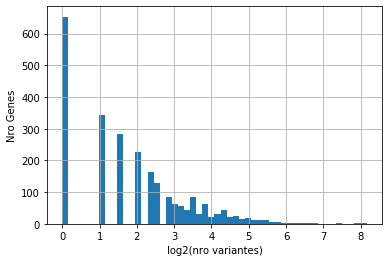

In [7]:
print('Nro unique genes: %s'%missenseHC.base_hugo.nunique())
ax = missenseHC.base_hugo.value_counts().apply(np.log2).hist(bins = 50)
plt.xlabel('log2(nro variantes)')
plt.ylabel('Nro Genes')

In [8]:
# Cuáles son los genes que pueden sesgar el análisis? 
missenseHC.base_hugo.value_counts().head()

TTN      287
BRCA1    229
BRCA2    182
LDLR     170
SYNE2    109
Name: base_hugo, dtype: int64

### Dropping, spliting and saving data

In [9]:
removecols = ['ClinicalSignificance','OriginSimple','base_hugo','base_achange']
modeling_data = missenseHC.drop(removecols,axis =1)
modeling_data.clinSigSimple = modeling_data.clinSigSimple.apply(lambda x: int(x))  # float to intiger
#"modeling_data.to_csv('./clinvarHC_modeling.csv',sep = ',')

In [12]:
X, y = modeling_data.drop(['clinSigSimple'],axis =1), modeling_data.clinSigSimple
display(X.shape)
y.shape

(17320, 39)

(17320,)

In [25]:
## retengo las Likely pathogenic por si acaso
missenseLP = missense[missense.clinSigSimple.isin([2])]  # reservo este dataset por si las moscas. 
X_LP, y_LP = missenseLP.drop(removecols,axis =1), missenseLP.clinSigSimple.apply(lambda x: int(x))

#### Guardamaos Datasets para construir el modelo. No obstante antes, exploremos un poco los datos

In [26]:
#X.to_csv('./workspace/clinvarHC_RawVariables.csv',sep = ',')
#y.to_csv('./workspace/clinvarHC_RawTarget.csv')

/home/ariel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


## Detectamos variables categóricas

In [11]:
categorical_feature_mask = X.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
categorical_columns

['interpro_domain_simple',
 'ess_gene_ess_gene',
 'ess_gene_ess_gene_crispr',
 'ess_gene_ess_gene_crispr2',
 'ess_gene_ess_gene_gene_trap',
 'exac_gene_exac_cnv_flag']

## Manipulación de variables categóricas

### existen varios métodos para lidiar con variables categóricas y ordinales. 
* Los más básicos son:
    *LabelEncoder (sktlearn)         # sólo para variables ordinales o binarias
    *OneHotEncoder (sktlearn)        # variables categóricas (binarias o multicategoricas)
    *GetDummies  (nativo de Pandas)  # variables categórcias 
    *DictVectorizer (nativo de Pandas)
#### Por simplicidad hoy sólo vamos a ver GetDummies (pero solo en esta etapa exploratoria de datos)
* Para construir el modelo necesitaremos de OneHotEncoder, o cualquier método que implemente métodos de tipo .fit_transform() 


In [12]:
# Get dummies
Xdummy = pd.get_dummies(X, prefix_sep='_', drop_first=True)
Xdummy.shape

(17320, 48)

#### Notar que ahora nuestro dataframe tiene 48 columnas

In [ ]:
#cg.ax_heatmap.get_
#cg.ax_heatmap.yaxis.get_ticklabels()

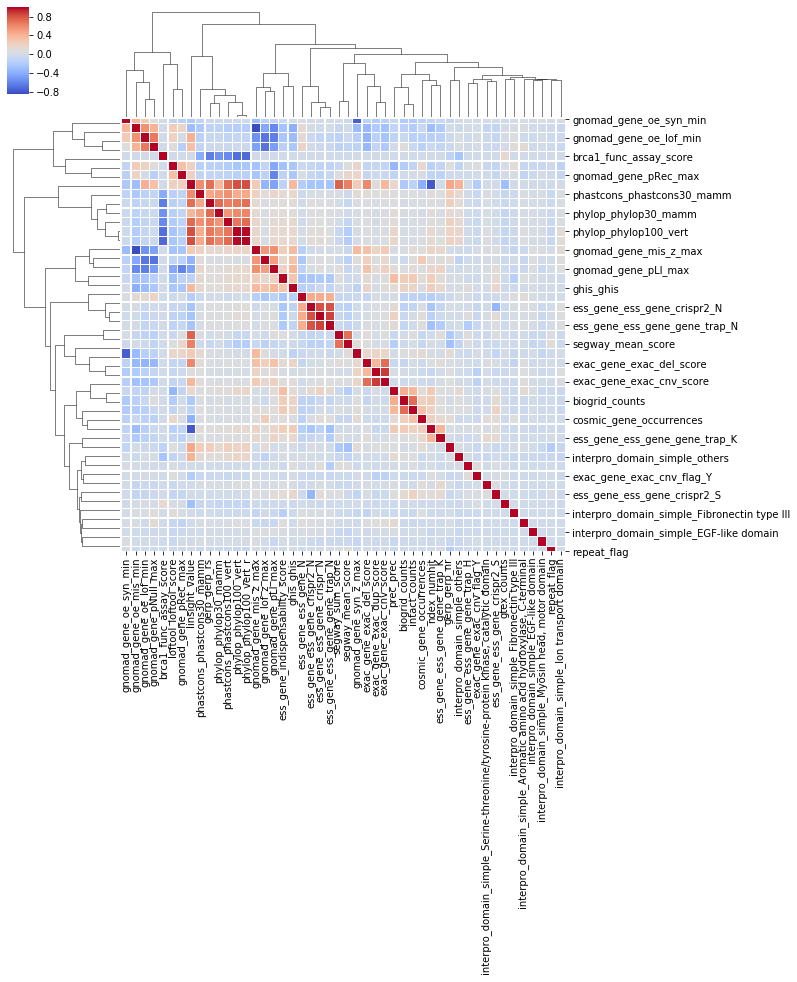

In [13]:
import seaborn as sns
corr = Xdummy.corr()

cg = sns.clustermap(corr.fillna(0), cmap ='coolwarm', linewidths = 0.2,
                    method = 'complete', xticklabels=1) 
cg

## Clustering. Homework, cómo se agrupan estos features?

In [196]:
from scipy.cluster.hierarchy import fcluster
linkage = cg.dendrogram_row.linkage

t = 0.9
clust = fcluster(linkage, t, criterion='inconsistent')

## Si quisiera cortar por numero de clusters:
#k = 10
#clust = fcluster(linkage, k, criterion='maxclust')
#clust


clusters = pd.DataFrame({'feature':Xdummy.columns,'cluster':clust}).sort_values(by = ['cluster'])
#clusters


### PCA

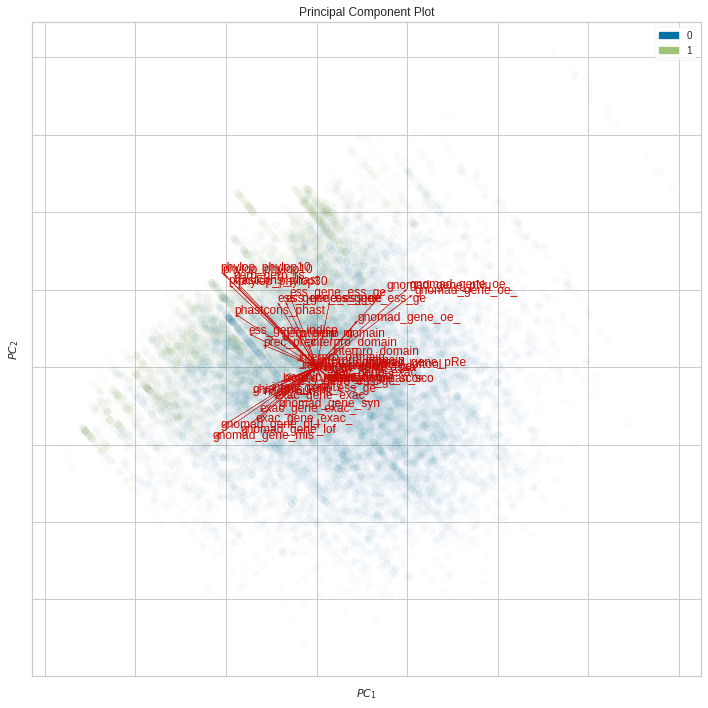

In [15]:
from yellowbrick.features import PCA
matplotlib.rcParams['figure.figsize'] = [10, 10]

xx = Xdummy.fillna(0)
xx.columns = [x[0:15] for x in X.columns]
visualizer = PCA(scale=True, proj_features=True, projection=2,alpha = 0.02,fontsize = 20)
visualizer.fit_transform(xx, y)
visualizer.show()


### Finalmente, preparo sets de entrenamiento:
* Porcentajes arbitrarios, sólo basados en la práctica y son dependientes de la cantidad de datos. 

* Training  Set (70%)         #Estos  lo usamos para entrenar el modelo


* Validation Set(20%)        #Este lo usamos para estimar el error del modelo.
* Test Set 10%.              #Este no lo tocamos nunca para entrenar ni para totmar decisiones. 




### Exploro proporción de Nulls en las variables  (algunos con gran cantidad!)
* Un modelo como regresion logística no admite Nulls. 
* Hay que imputarlos. La estrategia más simple sería con el valor medio de ese feature en el dataset. 

nans = Xdummy.apply(lambda a: a.isna().sum()/a.shape[0],axis =0)
p = nans[nans>0.1].plot(kind = 'bar',title = 'Principales features con Nulls')
p.set_ylabel('Null Fraction')
